# How to appropriately calculate frequency (or wavenumber) spectra? 
### Shane Elipot, selipot@miami.edu, @ShaneKahn

### Introduction and some theoretical aspects

With this notebook I want to show how to calculate windowed (or tapered) frequency (or wavenumber) spectra using python in a way that conserve the energy, or variance, of your original signal. If you would like more theoretical background information on spectral analyses, you can always head to my [online course on the topic](https://selipot.github.io/talks/lecture4/index.html#1).  

The values of a spectrum at a given frequency are random variables, which means that these values can be characterized by PDF functions. Just like any other random variables, they can **only be estimated**, not calculated exactly from actual data. This is a crucial point of *spectral estimation*. To estimate the spectrum at  *Fourier frequency* $f_n = n/( N \Delta t)$ of the variable $x$ for which we have a sequence, or time series, $(x_0, x_1,\ldots,x_{N-1})$, one non-parametric way (there are others) is as follows:

$$ 
\widehat{S}^{(d)}_n = \Delta t \left| \sum_{k=0}^{N-1} h_k x_k e^{-i 2 \pi n k /N}\right|^2 = \Delta t\, |\texttt{DFT(xh)}_n|^2,
\tag{1}
$$

which  means that we apply a Discrete Fourier Transform (DFT), usually a Fast Fourier Transform a.k.a. FFT, not to the sequence $x_k$ but to the sequence $h_k \times x_k$ where $h_k$ is the sequence for the taper which is used to improve our spectral estimate by reducing its variance. In the expression above, $\texttt{DFT(x)}_n = \sum_{k=0}^{N-1} x_k e^{-i2\pi n k/N} $ with  $n=0 \ldots N-1$, is the $N$-long sequence that is returned by the Matlab function $\texttt{fft(x)}$ and the Python Numpy function $\texttt{fft.fft(x)}$. This sort of implies that the common convention of these computational tools is $\Delta t = 1$.

Now, the frequency integral of $S^{(d)}_n$, in discrete form, can be shown to be (after some math, see [Percival and Walden 1993](https://books.google.com/books?hl=en&lr=&id=FubniGJ0ECQC&oi=fnd&pg=PR15&dq=percival+and+walden+1993&ots=mvIeL7vAJT&sig=uymCuxMP8Cjcy0g-hK12ipqQwzM)):

$$\frac{1}{N \Delta t}  \sum_{n=0}^{N-1} S_n^{(d)} = \frac{1}{N}\sum_{k=0}^{N-1} |x_k|^2 \sum_{k=0}^{N-1}h_k^2.\tag{2}$$


If we make sure that the taper sequence $h_k$ has unit energy (also said to be normalized), i.e. $\sum_{k=0}^{N-1}h_k^2=1$, then the above expression becomes

$$ \frac{1}{N \Delta t} \sum_{n=0}^{N-1} S_n^{(d)} = \frac{1}{N} \sum_{k=0}^{N-1} |x_k|^2 \equiv \widehat{\sigma}^2(x).\tag{3}$$

This last expression is the discrete version of *Parseval's theorem*, the interpretation of which is that the frequency integral of spectrum is equal to a variance estimate $\widehat{\sigma}^2(x)$ of the original sequence $x_k$, **if this sequence is zero-mean**. If the sequence $x_k$ is not zero-mean, the equality above is still applicable (but not the last equivalence) and the integral of the spectrum is simply the mean squared value of the sequence $x_k$.

In conclusion, $\widehat{S}^{(d)}_n = \Delta t\, |\texttt{DFT(xh)}_n|^2$ is an *taper estimate* (or windowed estimate?) of the *Power Spectral Density, or PSD*, as a function of *Fourier frequencies* $f_n = n/(N\Delta t)$, if the window is unit energy. If one has not made sure to normalize the window, then one needs to correct a posteriori the estimates by a constant $C=\sum_{k=0}^{N-1}h_k^2$. 

Now, we apply the above formula in various different ways to verify some available python methods.

### In practice:

We import the `numpy` module that contains functions to calculate Fourier transforms. The `scipy.signal` module is used to generate the tapers (or windows). We also import [`xrft`](https://xrft.readthedocs.io/en/latest/), a package  which applies FFT operations to `xarray` Datasets or DataArrays. 

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss 
import xarray as xr
import xrft

We generate a random complex time series called `z` which, for the sake of illustration, will be in units of        m/s as if `z` represented ocean velocity or atmospheric wind as an example. Optionally, we can make it "red" in character by taking the cumulative sum but removing the strong linear trend.

In [225]:
dt = 1/24 # define the time step in units of days
N = 1440 # Number of time step, i.e. 60 days 
u = 0.1*np.random.randn(N)
v = 0.1*np.random.randn(N)
z = u+1j*v;
# u = 0.1*np.random.randn(N).cumsum(axis=0)
# v = 0.1*np.random.randn(N).cumsum(axis=0)
# z = ss.detrend(u+1j*v);

We also build an *xarray* Dataset `za` which contains the DataArray `z` and a time coordinate of length 1440 hours (60 days). The Dataset object `za` will be used by `xrft`.

In [305]:
time = np.arange('2014-01-01T01:00:00','2014-03-02T01:00:00',np.timedelta64(1, "h"),dtype='datetime64[ns]')
za = xr.Dataset({'z': (['time'],z)},coords={'time':time})
za

<xarray.Dataset>
Dimensions:  (time: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T01:00:00 ... 2014-03-02
Data variables:
    z        (time) complex128 (0.23665079477476958+0.019030678504847066j) .....

We make a plot of the components of `z`:

Text(0, 0.5, 'm s$^{-1}$')

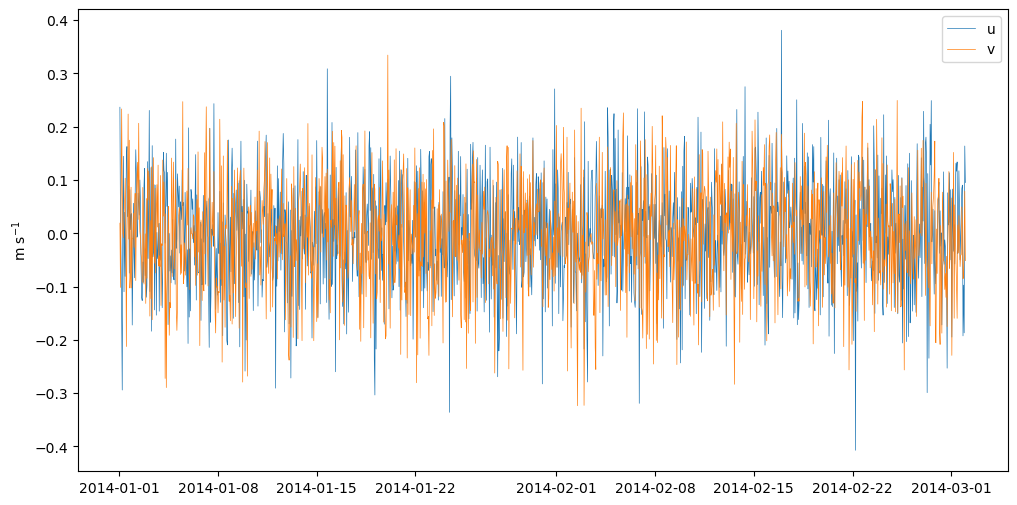

In [306]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 6))
h1, = plt.plot(time,z.real,linewidth=0.5)
h2, = plt.plot(time,z.imag,linewidth=0.5)
plt.legend([h1,h2],['u','v'])
ax.set_ylabel('m s$^{-1}$')

We next compute the Fourier frequencies which are defined by the length of the time series `z` using the `fftfreq` function from `numpy.fft`. Note that because `z` is complex, we are going to estimate a *rotary spectrum* for which the values of the spectrum at positive and negative frequencies are not necessarily the same, and the positive and negative frequencies have different meaning (see the [bivariate variable section](https://selipot.github.io/talks/lecture4/index.html#71) of my lecture on this). We also define the windowing sequences $h_k$ with *unit energy* which means that $\sum_k h_k^2=1$.


In [331]:
f = np.fft.fftfreq(z.shape[0],dt) # define frequency scale/abscissa, dt is in units of days

# define a rectangular window, i.e. boxcar, with unit energy
#foo = ss.windows.boxcar(z.shape[0])
foo = np.ones(z.shape[0])
boxcar_fac = np.square(foo).sum()
wr = foo/np.sqrt(boxcar_fac)

# define a Hann  window with unit energy
foo = ss.windows.hann(z.shape[0])
hann_fac = np.square(foo).sum()
wh = foo/np.sqrt(hann_fac)

# define a Slepian window with unit energy
foo = ss.windows.dpss(z.shape[0],3)
slepian_fac = np.square(foo).sum()
ws = foo/np.sqrt(slepian_fac)

# verify that the windows are both unit energy
print('boxcar window, sum of (h_k)^2:', sum(np.square(wr)))
print('Hann window, sum of (h_k)^2:', sum(np.square(wh)))
print('Slepian window, sum of (h_k)^2:', sum(np.square(ws)))

# correcting factors
print('Boxcar constant:', boxcar_fac)
print('Hann constant:', hann_fac)
print('Slepian constant:', slepian_fac)

boxcar window, sum of (h_k)^2: 0.9999999999999967
Hann window, sum of (h_k)^2: 1.000000000000001
Slepian window, sum of (h_k)^2: 0.9999999999999992
Boxcar constant: 1440.0
Hann constant: 539.625
Slepian constant: 425.00717267611924


You can see above that, within numerical precision, the windows have unit energy thanks to the division of the window sequences by the square root of their respective corrective constant factor, which we save for later use. 

Also, something to check: is `z` really zero-mean? Not exactly, because of the random number generation ... even if we force to substract the mean so that is something to keep in mind when interpreting the value of a spectrum at the zero frequency.

In [332]:
# what is the mean of z?
display(za.z.mean().values)
# what is the mean of z minus its mean? Not exactly 0.
display((za.z-za.z.mean()).mean().values)

array(-0.00190887-0.00426644j)

array(2.15876699e-18+4.62592927e-19j)

#### Estimating the spectrum, 7 ways ...

A first and straightforward way to estimate the spectrum is to apply `numpy.fft`, using a normalized *boxcar* window (`szz1` below). To illustrate my earlier point about the normalization, I also calculate the raw *periodogram* (`szz0`) which is equivalent to using a boxcar window which is not normalized, i.e. $h_k\equiv 1$ and $\sum_{k=0}^{N-1} h_k^2= N$. 

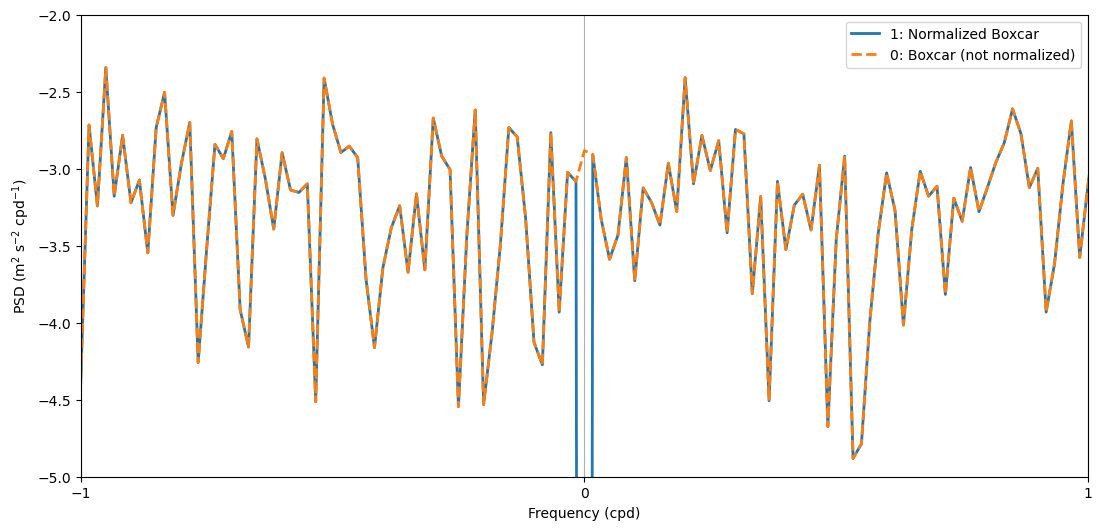

In [386]:
# As we saw above, subtracting the mean does not completely remove the mean numerically,
# so that the value of the spectrum at the zero frequency will be very very small and this will mess up 
# the automatic axis scaling. Let's see what happen if we do not remove the mean for the raw periodogram.
#zfft0 = np.fft.fft(z-np.mean(z)) # apply FFT
zfft0 = np.fft.fft(z) #
zfft1 = np.fft.fft((z-np.mean(z))*wr) # apply FFT after multiplying the input sequence by the normalized window
#zfft1 = np.fft.fft(z*wr) #

szz0 = (np.abs(zfft0)**2)*dt/boxcar_fac # PSD estimate with correction because of windowing, see eq. (1) above
szz1 = (np.abs(zfft1)**2)*dt # PSD estimate, no correction needed because the window is normalized
# szz1 = dt*zfft.conj()*zfft # this should be equivalent to above but does not return exactly a real quantity

# plotting to examine the difference, zooming on +/- 1 cpd
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
h1, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz1)),scaley=True,linewidth=2)
h2, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz0)),scaley=True,linewidth=2,linestyle='--')
ax.set_ylabel('PSD (m$^2$ s$^{-2}$ cpd$^{-1}$)')
ax.set_xlabel('Frequency (cpd)')
ax.set_xticks(np.arange(-12,13,1))
ax.set_xlim([-1,1])
ax.set_ylim([-5,-2])
ax.grid(axis='x')    
plt.legend([h1,h2], ['1: Normalized Boxcar','0: Boxcar (not normalized)'])
                                 

As expected, `szz0` and `szz1` are exactly the same, except at the zero frequency.

Using a boxcar window causes a lot of leakage from one frequency band to the next when estimating the spectrum. As such, we can use a better window such as the *Hann* window defined previously.

In [387]:
# Applying the Hann window, normalized
zfft2 = np.fft.fft((z-np.mean(z))*wh) # FFT
szz2 = (np.abs(zfft2)**2)*dt
szz2


array([1.57943752e-05, 1.09171271e-03, 5.86540014e-04, ...,
       1.64888187e-04, 2.76234095e-04, 2.83853734e-04])

In [388]:

# Applying a Slepian window, normalized
zfft3 = np.fft.fft((z-np.mean(z))*ws) # FFT
szz3 = (np.abs(zfft3)**2)*dt
szz3


array([7.53406439e-05, 8.09750543e-04, 5.10653482e-04, ...,
       2.40300395e-04, 1.74570740e-04, 1.94851366e-04])

Next, we also test the methods available with the `xrft` package. `xrft.fft` applies a FFT along the prescribed dimension, can apply a given window, and can subtract a constant (mean) or a linear trend to the data. Here for the FFT operation, we specify to apply a boxcar window, which is equivalent to `None` for the window argument, and we prescribe to remove the mean. Estimating the spectrum requires to take the square of the absilute value of the FFT, multiply by `dt`, and correct for the boxcar constant factor which is simply $N$.  

In [389]:
# Using xrft routine for FFT with no window, i.e a boxcar window. `xrft.fft` includes a true_amplitude optional argument that applies the multiplication by dt of the fft
# but that is not useful; not sure why it is used
zfft4 = xrft.fft(za.z,dim=['time'],window='boxcar',detrend='constant',true_amplitude=False,shift=False)
# multiply the absolute squared Fourier transform coefficients by dt to make a PSD and divide by correction for window
szz4 = (np.abs(zfft4)**2)*dt/(boxcar_fac)
# szz3 = (np.abs(zfft3)**2)*dt/N # this is equivalent because boxcar_fac = 1440 = N


In [390]:

# Using `xrft.fft` routine for FFT but with Hann window. 
zfft5 = xrft.fft(za.z,dim=['time'],window='hann',detrend='constant',true_amplitude=False,shift=False)
# multiply the absolute squared Fourier transform coefficients by dt to make a PSD and divide by correction for window
szz5 = (np.abs(zfft5)**2)*dt/hann_fac


In [391]:
# Using the `xrft.power_spectrum method` with the density option and the window correction option
# does not lead to the expected result. Looking at the source code, this function takes the square of the absolute of the
# FFT of the data but multiplies by the frequency resolution (scaling='density') and divide by the mean of the squares of the window sequence
# (window_correction=True).
# It divides by N^2 and the frequency spacing 1/(N dt) with dt in s?
# to correct, I multiply back by N^2 and 1/(N dt) as well as correct by the dt/hann_fac
# this to understand:
#szz6 = xrft.power_spectrum(za.z,dim=['time'],window='hann',detrend='constant',scaling='density',window_correction=True)
szz6 = (dt/hann_fac)*(1/(N*60*60))*N**2*xrft.power_spectrum(za.z,dim=['time'],window='hann',detrend='constant',shift=False,scaling='density')
szz6

<xarray.DataArray (freq_time: 1440)>
array([1.53868527e-05, 1.09449679e-03, 5.88967646e-04, ...,
       1.64274452e-04, 2.77471696e-04, 2.85369046e-04])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.929e-07 ... -3.858e-07 -1.929e-07

Let's verify that the integrals of the spectra equal approximately the variance, i.e. Parseval's theorem

In [393]:
print('   variance of z:',np.var(z,dtype=np.float64,ddof=1)) 

print('Integral of Szz0:', szz0.sum()*f[1])
print('Integral of Szz1:', szz1.sum()*f[1])
print('Integral of Szz2:', szz2.sum()*f[1])
print('Integral of Szz3:', szz3.sum()*f[1])
print('Integral of Szz4:', szz4.sum().values*f[1])
print('Integral of Szz5:', szz5.sum().values*f[1])
print('Integral of Szz6:', szz6.sum().values*f[1])


   variance of z: 0.020160056463052065
Integral of Szz0: 0.020149700207788095
Integral of Szz1: 0.020127853878877167
Integral of Szz2: 0.02029798060959831
Integral of Szz3: 0.020241084799255512
Integral of Szz4: 0.020127853878877167
Integral of Szz5: 0.02031242944991138
Integral of Szz6: 0.020312429449911375


/Users/selipot/opt/miniconda3/envs/research/lib/python3.9/site-packages/numpy/core/_methods.py:213: ComplexWarning: Casting complex values to real discards the imaginary part
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Make a figure after making NaN the zero frequency band for legibility:

(-1.0, 1.0)

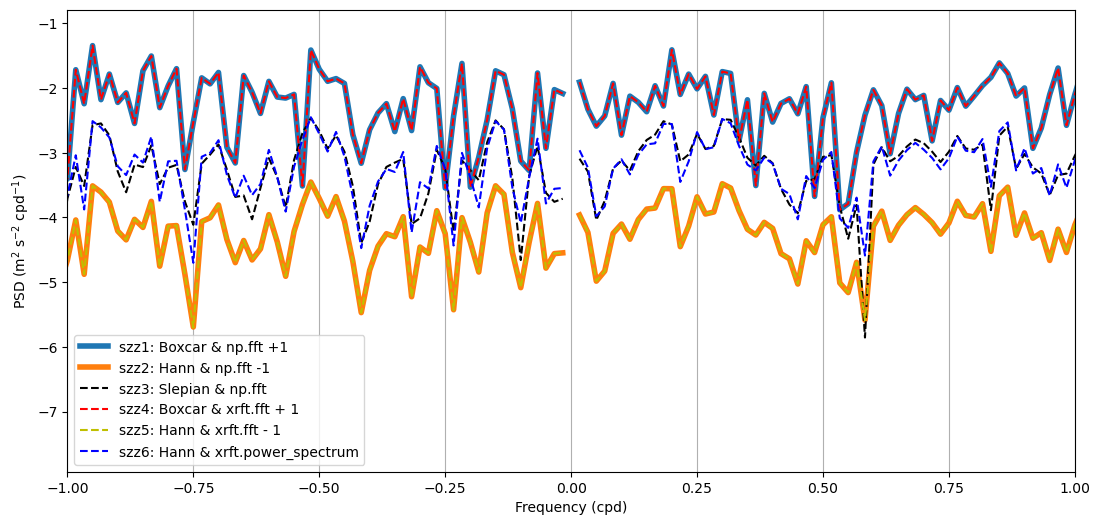

In [404]:
szz1[0] = np.nan
szz2[0] = np.nan
szz3[0] = np.nan
szz4[0] = np.nan
szz5[0] = np.nan
szz6[0] = np.nan

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
h1, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz1)+1),scaley=True,linewidth=4)
h2, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz2)-1),scaley=True,linewidth=4)
h3 , = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz3)),scaley=True,linestyle='dashed',color='k')
h4, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz4)+1),scaley=True,linestyle='dashed',color='r')
h5, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz5)-1),scaley=True,linestyle='dashed',color='y')
h6, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz6)),scaley=True,linestyle='dashed',color='b')

plt.legend([h1,h2,h3,h4,h5,h6], ['szz1: Boxcar & np.fft +1','szz2: Hann & np.fft -1','szz3: Slepian & np.fft','szz4: Boxcar & xrft.fft + 1',
    'szz5: Hann & xrft.fft - 1','szz6: Hann & xrft.power_spectrum'])
ax.set_ylabel('PSD (m$^2$ s$^{-2}$ cpd$^{-1}$)')
ax.set_xlabel('Frequency (cpd)')
ax.grid(axis='x')    
ax.set_xlim(xmin=-1, xmax=1)
#ax.set_ylim(ymin=-6, ymax=0)

In conclusion, all the estimates agree after applying the proper normalization and correcting factors for `xrft`.

#### A note about the Fourier frequencies

As mentionned above, the frequency resolution or spacing, the *Raleigh* frequency, is $1/(N\Delta t)$. The discrete Fourier frequencies $f_n=n/(N\Delta t)$ are therefore multiples of the Raleigh frequency. The highest resolvable frequency when estimating a spectrum is the *Nyquist* frequency $f_N = 1/(2\Delta t)$. As done above, we have calculated the Fourier frequencies thanks to the `numpy.fft.fftreq` and specifying the length of the time series ($N$) and the temporal spacing of the data sequence ($\Delta t$). This function returns the frequencies with units of cycles per unit of time (here, cycles per day). Note that the number of Fourier frequencies returned by this function is different if $N$ is odd or even (see the numpy [reference](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html) on the topic). This function returns both positive and negative frequencies, the interpretation of which is different when dealing with bivariate variable (as in this example). If you want only positive frequencies, you can use `numpy.fft.rfftreq`, see the [reference](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfftfreq.html).

If you are using the `xrft` package, the `fft` or `power_spectrum` objects return the coordinate `freq_time` with attribute `spacing` which correspond to the Fourier frequencies and Raleigh frequency, respectively. Since `xrft` works on DataArray objects with coordinates, it seems to have interpreted the units of the `time` coordinate and returned the frequencies in Hz.

In [405]:
#f = np.fft.fftfreq(z.shape[0],dt) # define frequency scale/abscissa, dt is in units of days
print(f) # frequencies in cycles per day
print(zfft4.freq_time.values*60*60*24) # frequencies in Hz (cycles per second) converted to cycles per day

[ 0.          0.01666667  0.03333333 ... -0.05       -0.03333333
 -0.01666667]
[ 0.          0.01666667  0.03333333 ... -0.05       -0.03333333
 -0.01666667]
